# Vanguard S&P 500 ETF Forecast

&emsp;This project builds a **predictive model** for the *Vanguard S&P 500 ETF* stock price.

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
mpl.style.use('seaborn-v0_8-colorblind')
%matplotlib inline

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.metrics import r2_score

# Seed code
np.random.seed(4)
random.seed(4)
tf.random.set_seed(4)

# Set environment variable for deterministic behavior
os.environ['PYTHONHASHSEED'] = str(4)

/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Create Windowed Dataset Function

In [2]:
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - window_size):
        window = orig_dataset.iloc[i:(i + window_size), 0]
        target = orig_dataset.iloc[i + window_size, 0]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

# Import Data

In [3]:
# Define the ticker symbol
ticker_symbol = "VOO"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
voo = ticker.history(period='max')  # data for the last year
print(f"Rows: {voo.shape[0]}\nColumns: {voo.shape[1]}")
voo.head()

Rows: 3627
Columns: 8


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-09-09 00:00:00-04:00,78.626477,78.626477,77.583237,77.721313,26500,0.0,0.0,0.0
2010-09-10 00:00:00-04:00,77.997503,78.135580,77.706012,78.074211,8600,0.0,0.0,0.0
2010-09-13 00:00:00-04:00,78.979376,79.117452,78.626516,79.056084,33750,0.0,0.0,0.0
2010-09-14 00:00:00-04:00,78.887289,79.378231,78.534430,79.040710,59400,0.0,0.0,0.0
2010-09-15 00:00:00-04:00,78.718569,79.301551,78.549808,79.240189,9250,0.0,0.0,0.0


In [4]:
voo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3627 entries, 2010-09-09 00:00:00-04:00 to 2025-02-07 00:00:00-05:00
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           3627 non-null   float64
 1   High           3627 non-null   float64
 2   Low            3627 non-null   float64
 3   Close          3627 non-null   float64
 4   Volume         3627 non-null   int64  
 5   Dividends      3627 non-null   float64
 6   Stock Splits   3627 non-null   float64
 7   Capital Gains  3627 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 255.0 KB


* Apparently, there are no missing values.
* For simplicity, `Close` will be used for the analysis and forecasting in the baseline models.

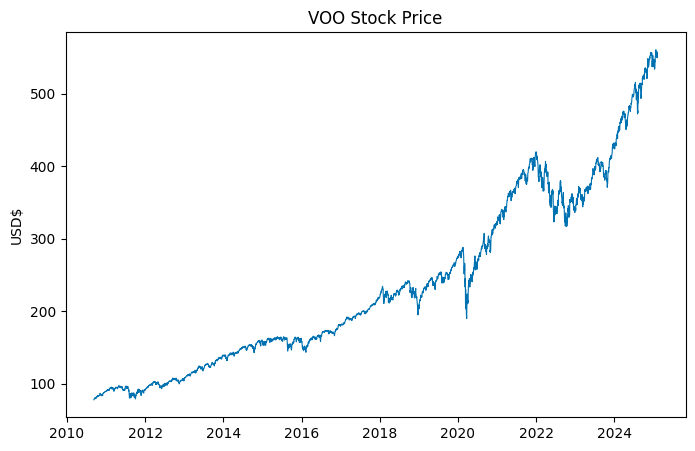

In [5]:
ticks = voo[['Close']]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ticks, lw=.8)
ax.set(title="VOO Stock Price", ylabel="USD$")
plt.show()

# Data Preprocessing

## Train Test Split

In [6]:
train = ticks[:int(ticks.shape[0] * .5)]
validate = ticks[int(ticks.shape[0] * .5): int(ticks.shape[0] * .75)]
test = ticks[int(ticks.shape[0] * .75):]
print(f'train: {train.shape}\nvalidate: {validate.shape}\ntest: {test.shape}')

train: (1813, 1)
validate: (907, 1)
test: (907, 1)


## Normalisation

In [7]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=['index'], index=train.index)
validate_scaled = pd.DataFrame(scaler.transform(validate), columns=['index'], index=validate.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=['index'], index=test.index)

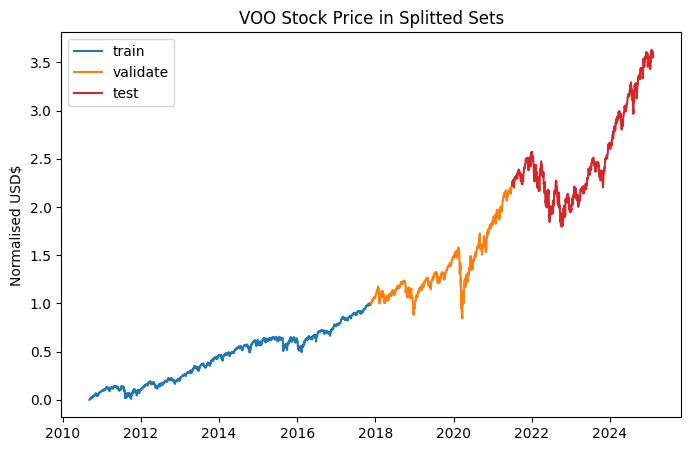

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_scaled, color='tab:blue', label='train')
ax.plot(validate_scaled, color='tab:orange', label='validate')
ax.plot(test_scaled, color='tab:red', label='test')
ax.legend()
plt.title("VOO Stock Price in Splitted Sets")
plt.xlabel("")
plt.ylabel("Normalised USD$")
plt.show()

## Windowed Datasets

In [9]:
window_size = 1
X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_val, y_val = create_dataset(validate_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1812, 1)
y_train: (1812,)
X_val: (906, 1)
y_val: (906,)
X_test: (906, 1)
y_test: (906,)


## Reshape for modelling

In [10]:
def reshape_df(df):
    return np.reshape(df, (df.shape[0], 1, df.shape[1]))

X_train_reshaped = reshape_df(X_train)
X_val_reshaped = reshape_df(X_val)
X_test_reshaped = reshape_df(X_test)

# Modelling

In [11]:
def model_eval(model, epochs=5):
    # Fit model
    model.fit(X_train_reshaped, y_train, epochs=5)

    # Make predictions on train and validate data
    train_pred = model.predict(X_train_reshaped)
    val_pred = model.predict(X_val_reshaped)
    test_pred = model.predict(X_test_reshaped)

    # Un-scale the predictions
    train_pred_rescaled = scaler.inverse_transform(train_pred)
    val_pred_rescaled = scaler.inverse_transform(val_pred)
    test_pred_rescaled = scaler.inverse_transform(test_pred)

    # Load in the original data (for comparison)
    baseline = ticks
    ########
    def rewindow_train_indexes(window, train_pred):
        return window, len(train_pred) + window

    def rewindow_val_indexes(window, train_pred, val_pred):
        return len(train_pred) + 2*window, len(train_pred) + 2*window + len(val_pred)

    def rewindow_test_indexes(window, train_pred, val_pred):
        return len(train_pred) + len(val_pred) + 3*window, None

    train_start, train_end = rewindow_train_indexes(window_size, train_pred_rescaled)
    val_start, val_end = rewindow_val_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
    test_start, test_end = rewindow_test_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
    ########
    # Un-window the training predictions
    plot_train_pred = np.empty((len(baseline)))
    plot_train_pred[:] = np.nan
    plot_train_pred[train_start:train_end] = train_pred_rescaled[:,0]
    # Un-window the validate predictions
    plot_val_pred = np.empty((len(baseline)))
    plot_val_pred[:] = np.nan
    plot_val_pred[val_start:val_end] = val_pred_rescaled[:,0]
    # Un-window the test predictions
    plot_test_pred = np.empty((len(baseline)))
    plot_test_pred[:] = np.nan
    plot_test_pred[test_start:test_end] = test_pred_rescaled[:,0]
    # Plot the original data
    plt.plot(baseline, label="Original Data")
    # Plot the predictions
    plt.plot(baseline.index, plot_train_pred, label="Training Set Predictions")
    plt.plot(baseline.index, plot_val_pred, label="Validation Set Predictions")
    plt.plot(baseline.index, plot_test_pred, label="Test Set Predictions")

    # Add title, axis labels, and a legend
    plt.title('VOO Stock Price Predictions by Training, Validation, and Test Sets')
    plt.xlabel('Date')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate()
    plt.xticks(rotation=45)
    plt.ylabel('Index')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

    print(f"R2 score for training: {r2_score(scaler.inverse_transform([y_train])[0], train_pred_rescaled)}")
    print(f"R2 score for validation: {r2_score(scaler.inverse_transform([y_val])[0], val_pred_rescaled)}")
    print(f"R2 score for test: {r2_score(scaler.inverse_transform([y_test])[0], test_pred_rescaled)}")

## Baseline Model - SimpleRNN

/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 786us/step - loss: 0.2516 
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 0.1029
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.0403
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - loss: 0.0244
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 0.0195
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


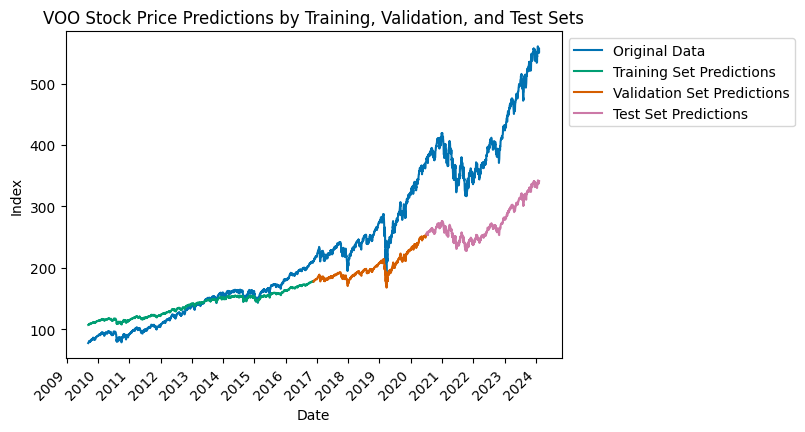

R2 score for training: 0.7830182708390434
R2 score for validation: -1.1415903391923314
R2 score for test: -4.188598717135111


In [12]:
# Modelling
model = tf.keras.Sequential()

model.add(layers.SimpleRNN(10, input_shape=(1, window_size), activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

model_eval(model, 5)

* The model only performs well for `training` set.
* After 2017, the trend of the index began to increase more steeply and erratically, the performance of the model fell as shown in `validation` and `test` sets' predictions.

## Model Tuning

X_train: (1788, 25)
y_train: (1788,)
X_val: (882, 25)
y_val: (882,)
X_test: (882, 25)
y_test: (882,)


/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - loss: 0.0423 
Epoch 2/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 0.0014   
Epoch 3/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017     
Epoch 4/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018     
Epoch 5/5
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011     
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step


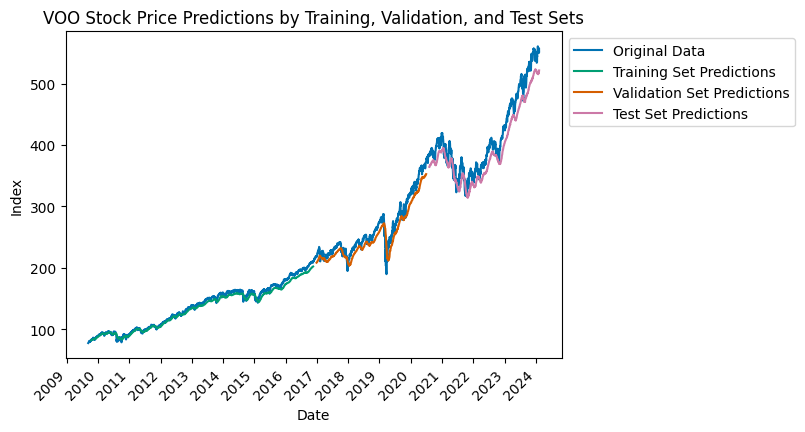

R2 score for training: 0.9810895157649804
R2 score for validation: 0.8910622412160185
R2 score for test: 0.8616953261893452


In [13]:
# Re-window datasets
window_size = 25
X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_val, y_val = create_dataset(validate_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")
# Reshaping
X_train_reshaped = reshape_df(X_train)
X_val_reshaped = reshape_df(X_val)
X_test_reshaped = reshape_df(X_test)

# Modelling
model = tf.keras.Sequential()

model.add(layers.Conv1D(128, 1, activation='relu', input_shape=(1, window_size)))
model.add(layers.MaxPooling1D(1))
model.add(layers.GRU(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer='rmsprop', loss='mean_squared_error')
model.summary()

model_eval(model, 40)

* A tuned `Convolutional-RNN` univariate model with a `GRU` layer significantly improves both the `validation` and `test` sets predictions with a slight difference in the $R^2$.

## Multivariate Model (adding `Volume`)

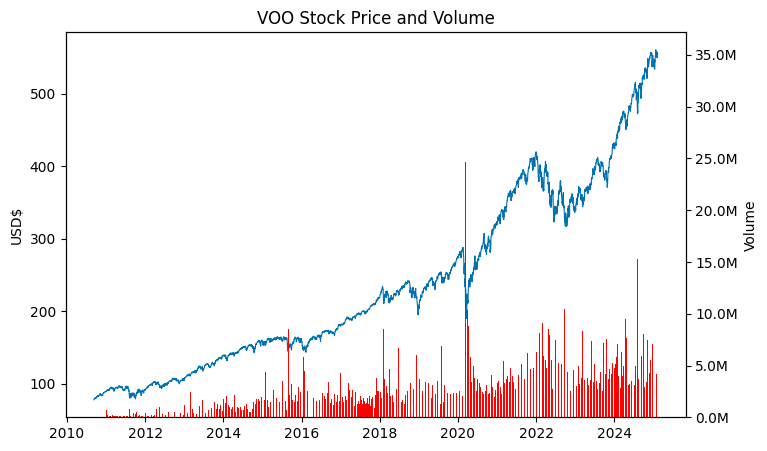

In [14]:
ticks_volume = voo[['Volume', 'Close']]

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ticks_volume['Close'], lw=.8)

ax2 = ax.twinx()
ax2.bar(ticks_volume.index, ticks_volume['Volume'], lw=.8, color='red')
ax2.set_ylabel('Volume')
ax2.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x / 1e6:.1f}M'))

ax.set(title="VOO Stock Price and Volume", ylabel="USD$")
plt.show()

* The plot above shows the `stock price` in blue and `volume` in red bars.
* Apparently, the higher the red bars, the more erratic and larger upward or downward movements.

In [15]:
# Train-Test Split
train = ticks_volume[:int(ticks_volume.shape[0] * .5)]
validate = ticks_volume[int(ticks_volume.shape[0] * .5): int(ticks_volume.shape[0] * .75)]
test = ticks_volume[int(ticks_volume.shape[0] * .75):]
print(f'train: {train.shape}\nvalidate: {validate.shape}\ntest: {test.shape}')

# Normalisation
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), columns=['Volume','Close'], index=train.index)
validate_scaled = pd.DataFrame(scaler.transform(validate), columns=['Volume','Close'], index=validate.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=['Volume','Close'], index=test.index)

train: (1813, 2)
validate: (907, 2)
test: (907, 2)


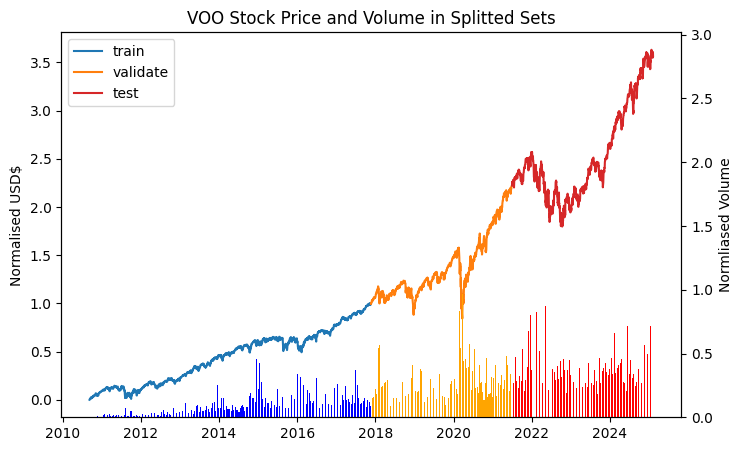

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(train_scaled['Close'], color='tab:blue', label='train')
ax.plot(validate_scaled['Close'], color='tab:orange', label='validate')
ax.plot(test_scaled['Close'], color='tab:red', label='test')
ax.set_ylabel("Normalised USD$")
ax.legend()

ax2 = ax.twinx()
ax2.bar(train_scaled.index, train_scaled['Volume'], lw=.8, color='blue')
ax2.bar(validate_scaled.index, validate_scaled['Volume'], lw=.8, color='orange')
ax2.bar(test_scaled.index, test_scaled['Volume'], lw=.8, color='red')
ax2.set_ylabel('Normliased Volume')

plt.title("VOO Stock Price and Volume in Splitted Sets")
plt.xlabel("")
plt.show()

X_train: (1723, 90, 2)
y_train: (1723,)
X_val: (817, 90, 2)
y_val: (817,)
X_test: (817, 90, 2)
y_test: (817,)


/Users/moswai/Documents/Mos_DataScience/tools/venv/venv_DL_tickers/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 2, 128)         │     1,036,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2, 256)         │     2,949,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 2, 128)         │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,173,889 (15.92 MB)

 Trainable params: 4,173,889 (15.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1433 - r2_score: -1.0971
Epoch 2/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0212 - r2_score: 0.6911
Epoch 3/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0167 - r2_score: 0.7559
Epoch 4/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0160 - r2_score: 0.7663
Epoch 5/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0124 - r2_score: 0.8189
Epoch 6/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0115 - r2_score: 0.8318
Epoch 7/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0111 - r2_score: 0.8388
Epoch 8/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0092 - r2_score: 0.8650
Epoch 9/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0079 - r2_score: 0.8847
Epoch 10/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0083 - r2_score: 0.8788
Epoch 11/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0077 - r2_score: 0.8880
Epoch 12/64
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.

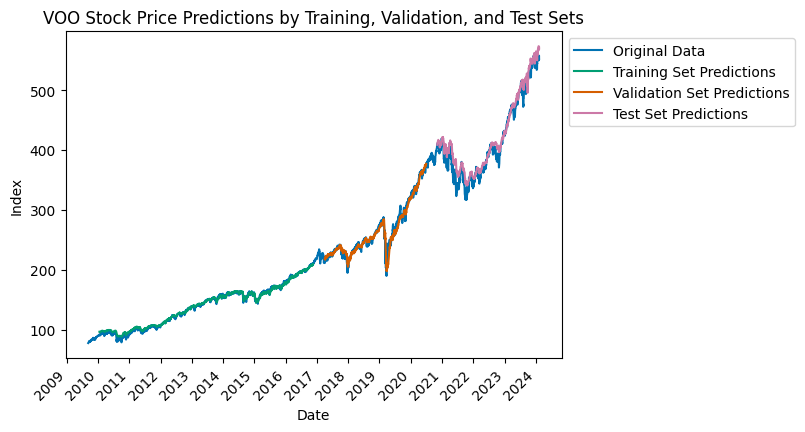

R2 score for training: 0.9930805199355524
R2 score for validation: 0.9774643082968624
R2 score for test: 0.9560847874860892


In [ ]:
# Re-window datasets
def create_dataset(orig_dataset, window_size=1):
    data_x, data_y = [], []
    for i in range(len(orig_dataset) - window_size):
        window = orig_dataset.iloc[i:(i + window_size), :]
        target = orig_dataset.iloc[i + window_size, 1]
        data_x.append(window)
        data_y.append(target)
    return np.array(data_x), np.array(data_y)

window_size = 90
X_train, y_train = create_dataset(train_scaled, window_size=window_size)
X_val, y_val = create_dataset(validate_scaled, window_size=window_size)
X_test, y_test = create_dataset(test_scaled, window_size=window_size)
print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}")
print(f"X_val: {X_val.shape}\ny_val: {y_val.shape}")
print(f"X_test: {X_test.shape}\ny_test: {y_test.shape}")

# Reshaping
def reshape_df(df):
    return np.reshape(df, (df.shape[0], 2, df.shape[1]))

X_train_reshaped = reshape_df(X_train)
X_val_reshaped = reshape_df(X_val)
X_test_reshaped = reshape_df(X_test)

# Modelling
model = tf.keras.Sequential()

model.add(layers.Conv1D(filters=128, kernel_size=window_size, padding='same', activation='relu', input_shape=(X_train_reshaped.shape[1], window_size)))
model.add(layers.Conv1D(filters=256, kernel_size=window_size, padding='same', activation='relu'))
model.add(layers.GRU(128, activation='relu', return_sequences=True))
model.add(layers.Dropout(.2))
model.add(layers.GRU(64, activation='relu', return_sequences=False))
model.add(layers.Dropout(.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(.2))
model.add(layers.Dense(1))

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['r2_score'])
model.summary()

model.fit(X_train_reshaped, y_train, epochs=64)

# Get predictions
train_pred = model.predict(X_train_reshaped)
val_pred = model.predict(X_val_reshaped)
test_pred = model.predict(X_test_reshaped)

# Un-scale the predictions
train_pred_rescaled = scaler.inverse_transform(np.hstack([np.zeros_like(train_pred), train_pred]))[:,1]
val_pred_rescaled = scaler.inverse_transform(np.hstack([np.zeros_like(val_pred), val_pred]))[:,1]
test_pred_rescaled = scaler.inverse_transform(np.hstack([np.zeros_like(test_pred), test_pred]))[:,1]

# Load in the original data (for comparison)
baseline = ticks

def rewindow_train_indexes(window, train_pred):
    return window, len(train_pred) + window

def rewindow_val_indexes(window, train_pred, val_pred):
    return len(train_pred) + 2*window, len(train_pred) + 2*window + len(val_pred)

def rewindow_test_indexes(window, train_pred, val_pred):
    return len(train_pred) + len(val_pred) + 3*window, None

train_start, train_end = rewindow_train_indexes(window_size, train_pred_rescaled)
val_start, val_end = rewindow_val_indexes(window_size, train_pred_rescaled, val_pred_rescaled)
test_start, test_end = rewindow_test_indexes(window_size, train_pred_rescaled, val_pred_rescaled)

# Un-window the training predictions
plot_train_pred = np.empty((len(baseline)))
plot_train_pred[:] = np.nan
plot_train_pred[train_start:train_end] = train_pred_rescaled
# Un-window the validate predictions
plot_val_pred = np.empty((len(baseline)))
plot_val_pred[:] = np.nan
plot_val_pred[val_start:val_end] = val_pred_rescaled
# Un-window the test predictions
plot_test_pred = np.empty((len(baseline)))
plot_test_pred[:] = np.nan
plot_test_pred[test_start:test_end] = test_pred_rescaled
# Plot the original data
plt.plot(baseline, label="Original Data")
# Plot the predictions
plt.plot(baseline.index, plot_train_pred, label="Training Set Predictions")
plt.plot(baseline.index, plot_val_pred, label="Validation Set Predictions")
plt.plot(baseline.index, plot_test_pred, label="Test Set Predictions")

# Add title, axis labels, and a legend
plt.title('VOO Stock Price Predictions by Training, Validation, and Test Sets')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()
plt.xticks(rotation=45)
plt.ylabel('Index')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"R2 score for training: {r2_score(scaler.inverse_transform(np.vstack([np.zeros_like(y_train), y_train]).transpose())[:,1], train_pred_rescaled)}")
print(f"R2 score for validation: {r2_score(scaler.inverse_transform(np.vstack([np.zeros_like(y_val), y_val]).transpose())[:,1], val_pred_rescaled)}")
print(f"R2 score for test: {r2_score(scaler.inverse_transform(np.vstack([np.zeros_like(y_test), y_test]).transpose())[:,1], test_pred_rescaled)}")

* A more complex `Convolutional RNN model` is built using two features, `Volume` and `Close`.
* Since the model consists of `Dropout` layers, the performance of the model slightly fluctuates.
* In general, the performance on test set is moderate or better.

# Prediction

In [171]:
window.shape

(1, 2, 90)

(1, 2, 90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)


/var/folders/_6/8qgcbw5x5cqgmt_5s5b28mpw0000gn/T/ipykernel_15920/1548139469.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  window[-1] = y_pred # Replace last value with prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(1, 1)


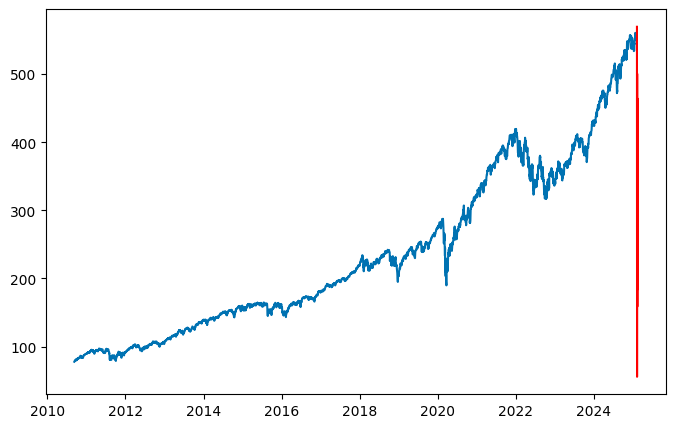

In [ ]:
def predictions(steps):
    y_preds = [] # Store predictions
    y_dates = pd.date_range(start=ticks.index[-1] + pd.Timedelta(days=1), periods=steps, freq='D') # Corresponding dates
    window = np.expand_dims(X_test_reshaped[-1, :, :], axis=0) # Last available data
    for i in range(steps):
        y_pred = model.predict(window) # One-step prediction
        print(y_pred.shape)
        y_preds.append(y_pred[0,0]) # Add prediction
        window = np.roll(window.flatten(), -1) # Roll window by -1
        window[-1] = y_pred # Replace last value with prediction
        window = np.reshape(window, (1,2,90))
    
    y_preds = scaler.inverse_transform(np.vstack([np.zeros_like(y_preds), y_preds]).transpose())[:,1]
    
    return pd.DataFrame({"Close":y_preds}, index=y_dates)

preds = predictions(10)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ticks)
ax.plot(preds, color='red')
plt.show()

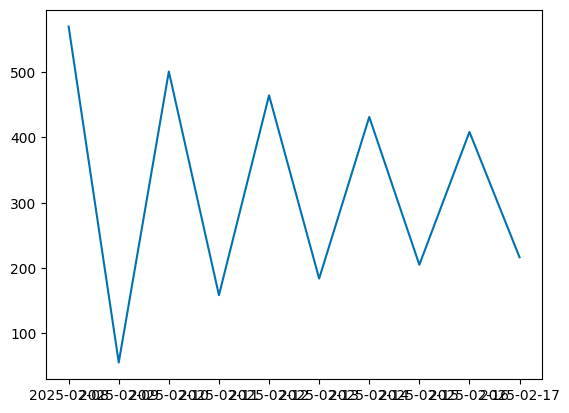

In [161]:
plt.plot(preds)

In [ ]:
future_dates = pd.date_range(start=ticks.index[-1] + pd.Timedelta(days=1), periods=40, freq='D')

DatetimeIndex(['2025-02-08 00:00:00-05:00', '2025-02-09 00:00:00-05:00',
               '2025-02-10 00:00:00-05:00', '2025-02-11 00:00:00-05:00',
               '2025-02-12 00:00:00-05:00', '2025-02-13 00:00:00-05:00',
               '2025-02-14 00:00:00-05:00', '2025-02-15 00:00:00-05:00',
               '2025-02-16 00:00:00-05:00', '2025-02-17 00:00:00-05:00',
               '2025-02-18 00:00:00-05:00', '2025-02-19 00:00:00-05:00',
               '2025-02-20 00:00:00-05:00', '2025-02-21 00:00:00-05:00',
               '2025-02-22 00:00:00-05:00', '2025-02-23 00:00:00-05:00',
               '2025-02-24 00:00:00-05:00', '2025-02-25 00:00:00-05:00',
               '2025-02-26 00:00:00-05:00', '2025-02-27 00:00:00-05:00',
               '2025-02-28 00:00:00-05:00', '2025-03-01 00:00:00-05:00',
               '2025-03-02 00:00:00-05:00', '2025-03-03 00:00:00-05:00',
               '2025-03-04 00:00:00-05:00', '2025-03-05 00:00:00-05:00',
               '2025-03-06 00:00:00-05:00', '2025-0